In [1]:
import numpy as np
import glob
import os
import cv2
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import json
import matplotlib.pylab as plt
%matplotlib inline

%load_ext autoreload

%autoreload 2

In [3]:
# https://raw.githubusercontent.com/ApolloScapeAuto/dataset-api/master/car_instance/car_models.py
from car_models import car_name2id, car_id2name
from utils import euler_to_rot, draw_obj, get_avg_size, get_intrinsics


In [4]:
import numpy as np
import glob
import os
import cv2
import pandas as pd
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

In [4]:
def read_json(json_file):
    with open(json_file, 'r') as f_in:
        data = json.load(f_in)
    return data

def write_json(data, json_file):
    os.makedirs(os.path.dirname(json_file), exist_ok=True)
    with open(json_file, 'w') as f_out:
        json.dump(data, f_out, sort_keys=True, indent=4)

In [4]:
def get_iou(bb1, bb2):
    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def get_bb_dict(xmin, ymin, xmax, ymax):
    bb_dict = {
        'x1': xmin,
        'x2': xmax,
        'y1': ymin,
        'y2': ymax
    }
    return bb_dict

In [5]:
basedir = '/Users/pliu/Downloads/pku_kaggle_data/'
model_files = glob.glob(os.path.join(basedir, 'car_models_json/*json'))
len(model_files)

79

## Load model

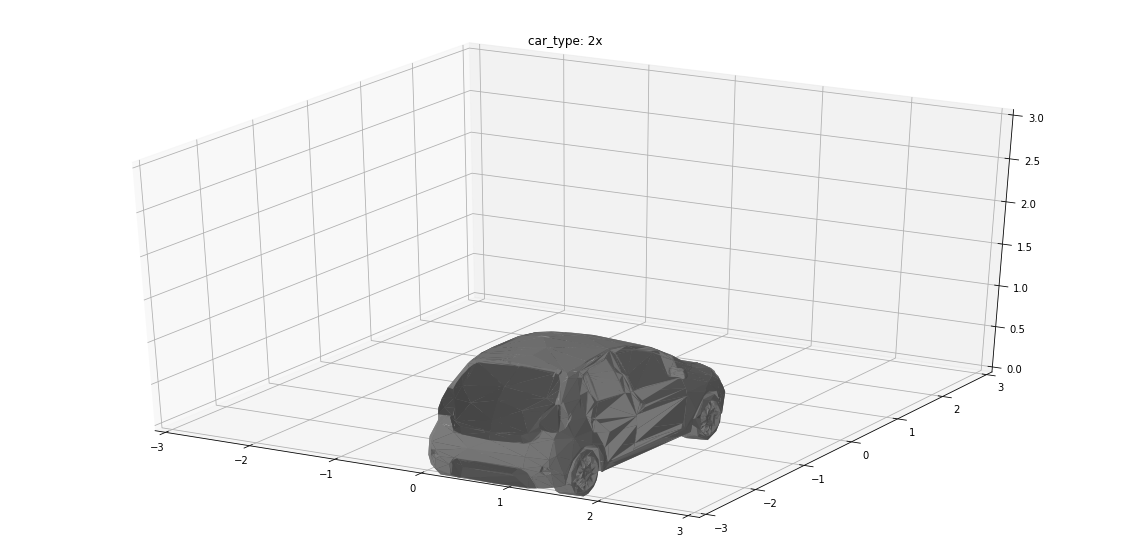

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

with open(model_files[0]) as json_file:
    data = json.load(json_file)
    vertices = np.array(data['vertices'])
    triangles = np.array(data['faces']) - 1
    plt.figure(figsize=(20,10))
    ax = plt.axes(projection='3d')
    ax.set_title('car_type: '+data['car_type'])
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([0, 3])
    ax.plot_trisurf(vertices[:,0], vertices[:,2], triangles, -vertices[:,1], shade=True, color='grey')

## car size analysis

In [7]:
def get_WHL(model_file):
    with open(model_file) as json_file:
        data = json.load(json_file)
    car_type = data['car_type']
    vertices = np.array(data['vertices'])
    triangles = np.array(data['faces']) - 1
    W, H, L = np.array(data['vertices']).max(axis=0) - np.array(data['vertices']).min(axis=0)
    model_name = os.path.basename(model_file).split('.json')[0]
    return W, H, L, car_type, model_name

def get_category_id_dict():
    category_id_dict = {}
    for x in car_id2name.values():
        category_id_dict[x.category] = x.categoryId
    return category_id_dict

In [8]:
category_id_dict = get_category_id_dict()
W_list = []
H_list = []
L_list = []
car_type_list = []
model_name_list = []
for model_file in model_files:
    W, H, L, car_type, model_name = get_WHL(model_file)
    W_list.append(W)
    H_list.append(H)
    L_list.append(L)
    car_type_list.append(car_type)
    model_name_list.append(model_name)


In [9]:
# Build df_size
size_list = np.array([W_list, H_list, L_list]).T
category_id_list = [category_id_dict[x] for x in car_type_list]
df_size = pd.DataFrame()
df_size['W'] = W_list
df_size['H'] = H_list
df_size['L'] = L_list

df_size['car_type'] = car_type_list
df_size['category_id'] = category_id_list
df_size['model_name'] = model_name_list

df_size['volume'] = df_size['W'] * df_size['H'] * df_size['L']

print('len(df_size)', len(df_size))
df_size.head()

len(df_size) 79


W         H         L car_type  category_id         model_name  \
0  1.861248  1.555801  3.740924       2x            0  jilixiongmao-2015   
1  2.170029  1.758379  4.824638      SUV            2         benchi-SUR   
2  1.817943  1.477863  4.495478       2x            0  bieke-yinglang-XT   
3  2.043992  1.703700  4.468129      SUV            2         jili-boyue   
4  1.918776  1.406800  4.909814       3x            1         biyadi-qin   

      volume  
0  10.832708  
1  18.409526  
2  12.077866  
3  15.559584  
4  13.253224

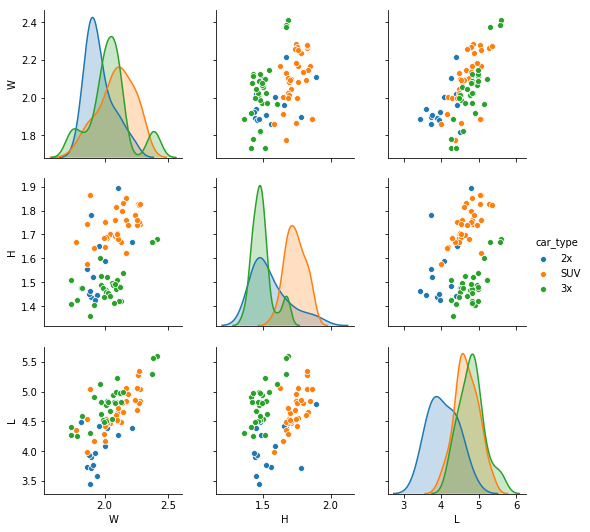

In [10]:
sns.pairplot(df_size[['W', 'H', 'L', 'car_type']], hue='car_type')

In [11]:
avg_size_dict = {}
for c_type in df_size['car_type'].unique():
    avg_size_dict[c_type] = {}
    df_tmp = df_size[df_size['car_type'] == c_type]
    closest_to_med_idx = (df_tmp['volume'] - df_tmp.median()['volume']).abs().argsort().to_list()[0]
    median_model_name = df_tmp.iloc[closest_to_med_idx]['model_name']
    w, h, l, model_name = df_tmp.iloc[closest_to_med_idx][['W', 'H', 'L', 'model_name']]
    avg_size_dict[c_type]['W'] = w
    avg_size_dict[c_type]['H'] = h
    avg_size_dict[c_type]['L'] = l
    avg_size_dict[c_type]['model'] = model_name

In [12]:
avg_size_dict

{'2x': {'W': 1.81794264,
  'H': 1.47786305,
  'L': 4.49547776,
  'model': 'bieke-yinglang-XT'},
 'SUV': {'W': 2.10604523,
  'H': 1.67994469,
  'L': 4.73350861,
  'model': 'biyadi-tang'},
 '3x': {'W': 1.9739563700000002,
  'H': 1.4896684399999998,
  'L': 4.83009344,
  'model': 'dazhongmaiteng'}}

## load image and render mask

In [5]:
basedir = '/Users/pliu/Downloads/pku_kaggle_data/'
image_dir = '/Users/pliu/Downloads/pku_kaggle_data/train_images'
model_dir = '/Users/pliu/Downloads/pku_kaggle_data/car_models_json'

In [13]:
from car_renderer import Visualizer
vis = Visualizer(basedir=basedir, image_dir=image_dir, model_dir=model_dir, save_dir=None)
len(vis.model_files)

79

In [16]:
# Load an image
img_name = 'ID_001d6829a' 
img = vis.load_image(img_name)

image size is H=2710, W=3384


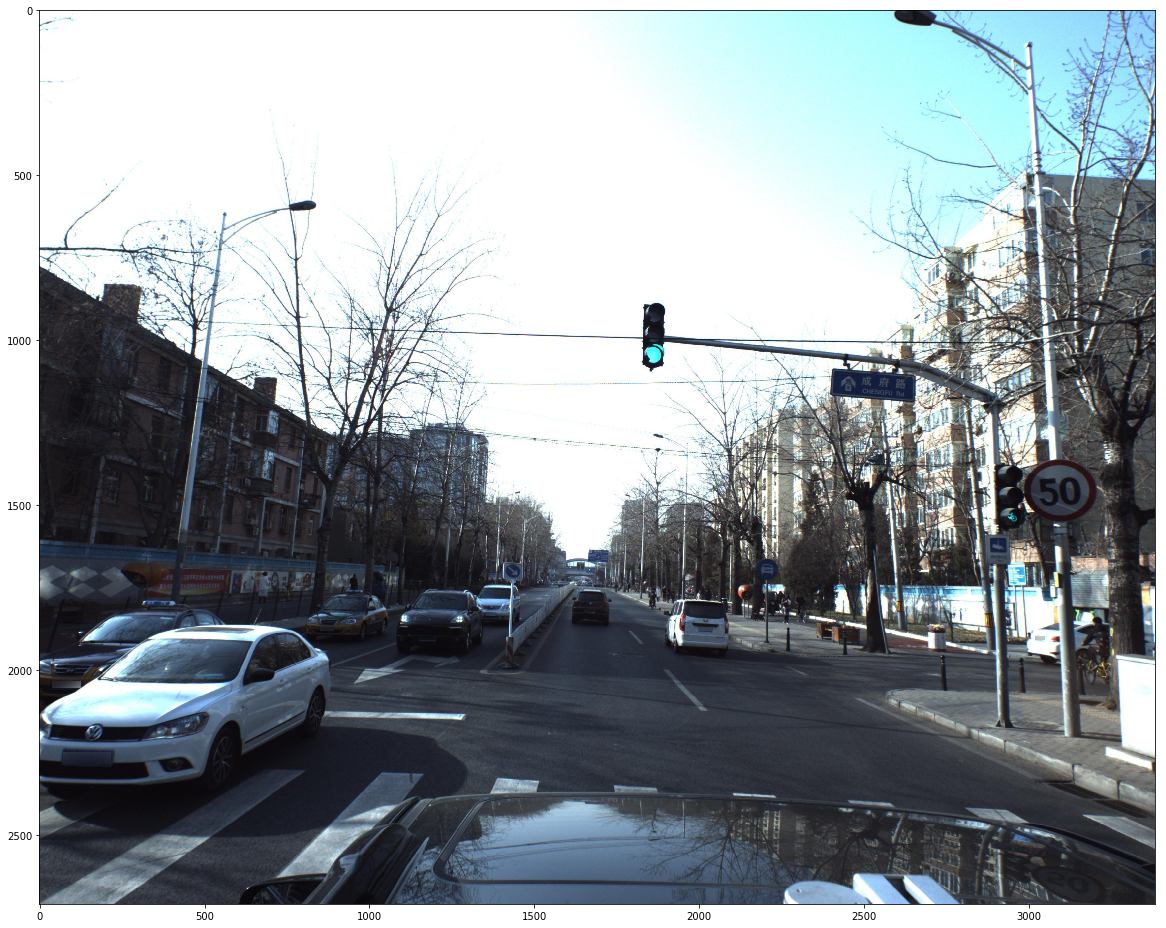

In [17]:
plt.figure(figsize=(20, 20))
plt.imshow(img);

image size is H=2710, W=3384


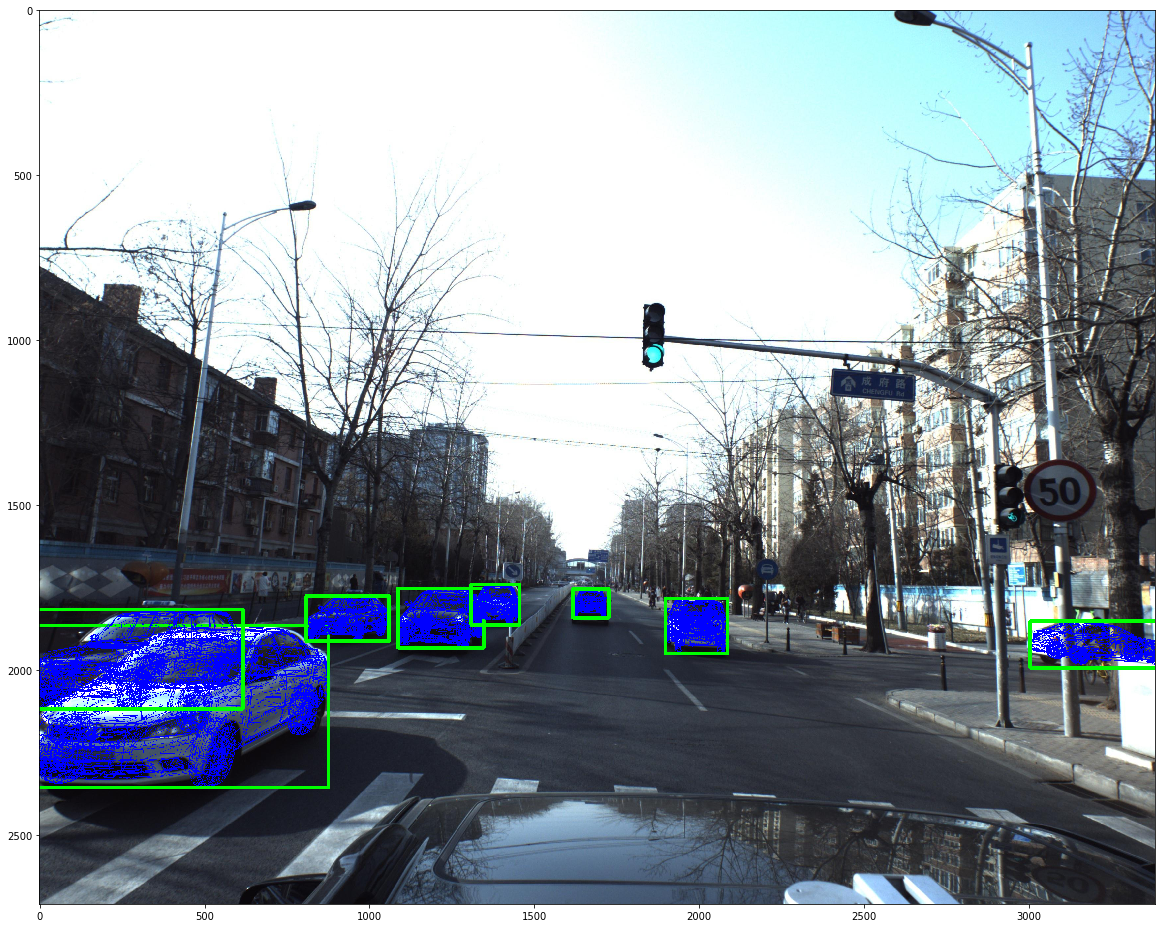

In [20]:
overlay, bboxes = vis.process(img_name)

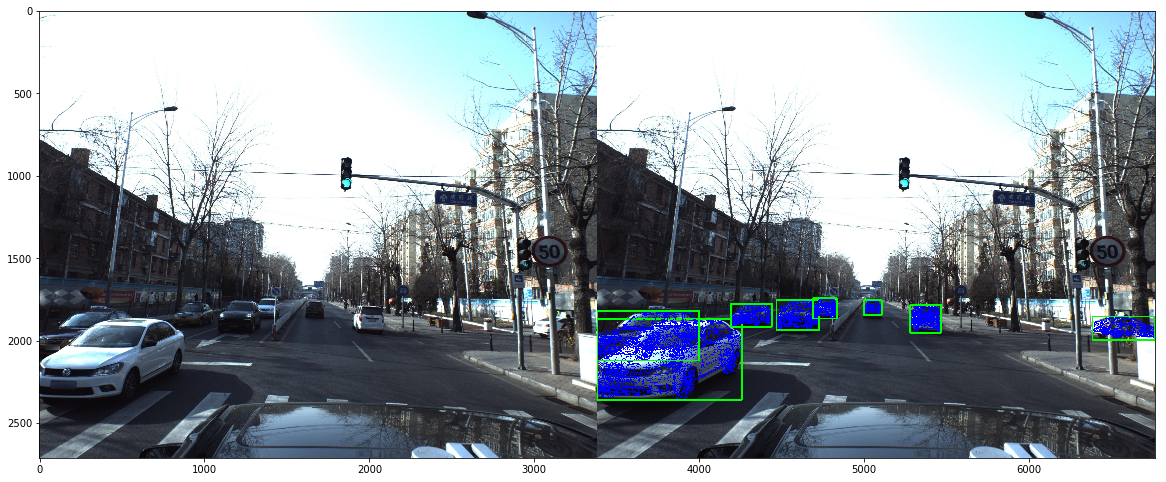

In [19]:
plt.figure(figsize=(20, 10))
plt.imshow(np.hstack([img, overlay[...]]))